In [2]:
library(ggplot2)
library(reshape2)

### Funciones Utilitarias (plot, lectura de archivos)

In [39]:
plot_fitness_over_time <- function(best_fitness, population_fitness, generations) {
  best_fitness_data <- data.frame(Generation = 1:generations, BestFitness = best_fitness)
  population_fitness_data <- melt(population_fitness)
  colnames(population_fitness_data) <- c("Individual", "Generation", "Fitness")
  
  p <- ggplot() +
    geom_violin(data = population_fitness_data, aes(x = Generation, y = Fitness, group = Generation), fill = "gray", alpha = 0.5) +
    geom_line(data = best_fitness_data, aes(x = Generation, y = BestFitness), color = "blue", size = 1) +
    labs(title = "Evolución del Fitness a lo Largo de las Generaciones", x = "Generación", y = "Fitness") +
    theme_minimal()
  
  print(p)
}


In [65]:
plot_fitness <- function(generations, best_fitness, average_fitness) {
  fitness_data <- data.frame(
    Generation = 1:generations,
    BestFitness = best_fitness,
    AverageFitness = average_fitness
  )
  
  ggplot(fitness_data, aes(x = Generation)) +
    geom_line(aes(y = BestFitness, color = "Best Fitness"), size = 1) +
    geom_line(aes(y = AverageFitness, color = "Average Fitness"), size = 1, linetype = "dashed") +
    scale_color_manual(values = c("Best Fitness" = "blue", "Average Fitness" = "green")) +
    labs(title = "Best and Average Fitness Over Generations", x = "Generations", y = "Fitness") +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
      axis.title = element_text(size = 12),
      legend.title = element_blank()
    )
}

# Función para graficar la diversidad de la población
plot_diversity <- function(generations, diversity) {
  diversity_data <- data.frame(Generation = 1:generations, Diversity = diversity)
  ggplot(diversity_data, aes(x = Generation, y = Diversity)) +
    geom_line(color = "red", size = 1) +
    labs(title = "Population Diversity Over Generations", x = "Generations", y = "Diversity") +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
      axis.title = element_text(size = 12)
    )
}


In [41]:
read_bin_packing_instance <- function(filename) {
  lines <- readLines(filename)
  P <- as.integer(lines[1])  # Número de instancias de problemas
  problems <- list()
  index <- 2
  for (i in 1:P) {
    problem_id <- trimws(lines[index])
    index <- index + 1
    bin_info <- strsplit(trimws(lines[index]), "\\s+")[[1]]
    bin_capacity <- as.numeric(bin_info[1])
    num_items <- as.integer(bin_info[2])
    best_known_solution <- as.integer(bin_info[3])
    index <- index + 1
    items <- numeric(num_items)
    for (j in 1:num_items) {
      items[j] <- as.numeric(trimws(lines[index]))
      index <- index + 1
    }
    problems[[i]] <- list(
      problem_id = problem_id,
      bin_capacity = bin_capacity,
      num_items = num_items,
      best_known_solution = best_known_solution,
      items = items
    )
  }
  return(problems)
}

### Definición de la clase de bin packing

In [36]:
BinPacking <- setRefClass(
  "BinPacking",
  fields = list(
    item_sizes = "numeric",
    bin_capacity = "numeric"
  ),
  methods = list(
    evaluate = function(permutation) {
      bin_capacities <- numeric() 
      current_bin_capacity <- 0  

      for (i in permutation) {
        item_size <- item_sizes[i]
        if (current_bin_capacity + item_size <= bin_capacity) {
          current_bin_capacity <- current_bin_capacity + item_size
        } else {
          bin_capacities <- c(bin_capacities, current_bin_capacity) 
          current_bin_capacity <- item_size  
        }
      }
      bin_capacities <- c(bin_capacities, current_bin_capacity)  
      return(length(bin_capacities)) 
    }
  )
)

#### Evaluación de la función

In [37]:
fitness_function <- function(permutation) {
  bp$evaluate(permutation)
}

#### Generación inicial de la población

In [38]:
generate_initial_population <- function(size, n) {
  replicate(size, sample(1:n), simplify = FALSE)
}

### Selección de individuos (roulette, rank, tournament) a través de los padres

In [31]:
select_individual <- function(fitness_vector, selection_method = "tournament", tournament_size = 3, verbose = FALSE) {
  if (!selection_method %in% c("roulette", "rank", "tournament")) {
    stop("The selection method must be 'roulette', 'rank', or 'tournament'.")
  }

  if (selection_method == "roulette") {
    selection_probability <- fitness_vector / sum(fitness_vector)
    selected_index <- sample(1:length(fitness_vector), size = 1, prob = selection_probability)
  } else if (selection_method == "rank") {
    selection_probability <- 1 / rank(-fitness_vector)
    selected_index <- sample(1:length(fitness_vector), size = 1, prob = selection_probability)
  } else if (selection_method == "tournament") {
    tournament_indices <- sample(1:length(fitness_vector), size = tournament_size)
    selected_index <- tournament_indices[which.min(fitness_vector[tournament_indices])]
  }

  if (verbose) {
    cat("----------------------", "\n")
    cat("Selected Individual", "\n")
    cat("----------------------", "\n")
    cat("Selection Method    =", selection_method, "\n")
    cat("Selected Index =", selected_index, "\n")
  }

  return(selected_index)
}


In [32]:
select_parents <- function(population, fitness, selection_method = "tournament", tournament_size = 3) {
  selected <- vector("list", length(population))
  for (i in 1:length(population)) {
    selected_index <- select_individual(fitness, selection_method, tournament_size)
    selected[[i]] <- population[[selected_index]]
  }
  return(selected)
}


### Función para introducir diversidad

In [30]:
introduce_diversity <- function(population, diversity_threshold = 0.9) {
  n <- length(population[[1]])
  unique_individuals <- length(unique(sapply(population, paste, collapse = "")))
  if (unique_individuals / length(population) < diversity_threshold) {
    num_new_individuals <- length(population) - unique_individuals
    new_individuals <- generate_initial_population(num_new_individuals, n)
    population[(unique_individuals + 1):length(population)] <- new_individuals
  }
  return(population)
}

### Métodos de crossover (uniform, one point, two point)

In [27]:

uniform_crossover <- function(parent1, parent2) {
  size <- length(parent1)
  child1 <- rep(-1, size)
  child2 <- rep(-1, size)
  used1 <- integer(0)
  used2 <- integer(0)
  
  # Selección aleatoria de genes
  for (i in seq_len(size)) {
    if (runif(1) < 0.5) {
      if (!(parent1[i] %in% used1)) {
        child1[i] <- parent1[i]
        used1 <- c(used1, parent1[i])
      }
    } else {
      if (!(parent2[i] %in% used1)) {
        child1[i] <- parent2[i]
        used1 <- c(used1, parent2[i])
      }
    }
    
    if (runif(1) < 0.5) {
      if (!(parent1[i] %in% used2)) {
        child2[i] <- parent1[i]
        used2 <- c(used2, parent1[i])
      }
    } else {
      if (!(parent2[i] %in% used2)) {
        child2[i] <- parent2[i]
        used2 <- c(used2, parent2[i])
      }
    }
  }
  
  # Rellenar los genes faltantes en child1
  missing1 <- parent1[!(parent1 %in% used1)]
  j <- 1
  for (i in seq_len(size)) {
    if (child1[i] == -1) {
      child1[i] <- missing1[j]
      j <- j + 1
    }
  }
  
  # Rellenar los genes faltantes en child2
  missing2 <- parent2[!(parent2 %in% used2)]
  j <- 1
  for (i in seq_len(size)) {
    if (child2[i] == -1) {
      child2[i] <- missing2[j]
      j <- j + 1
    }
  }
  
  return(list(child1 = child1, child2 = child2))
}

In [28]:
one_point_crossover <- function(parent1, parent2) {
  size <- length(parent1)
  cut <- sample(2:(size - 1), 1) 
  
  child1 <- c(parent1[1:cut], parent2[(cut + 1):size])
  child2 <- c(parent2[1:cut], parent1[(cut + 1):size])
  
  return(list(child1, child2))
}

In [29]:
two_point_crossover <- function(parent1, parent2) {
  size <- length(parent1)
  cuts <- sort(sample(0:(size - 1), 2))
  cut1 <- cuts[1]
  cut2 <- cuts[2]
  
  child1 <- rep(NA, size)
  child2 <- rep(NA, size)
  
  child1[(cut1 + 1):cut2] <- parent1[(cut1 + 1):cut2]
  child2[(cut1 + 1):cut2] <- parent2[(cut1 + 1):cut2]
  
  used1 <- parent1[(cut1 + 1):cut2]
  j <- (cut2 + 1) %% size
  if (j == 0) j <- size
  
  for (i in 1:size) {
    if (!(parent2[i] %in% used1)) {
      while (!is.na(child1[j])) {
        j <- (j %% size) + 1
        if (j == 0) j <- size
      }
      child1[j] <- parent2[i]
    }
  }
  
  used2 <- parent2[(cut1 + 1):cut2]
  j <- (cut2 + 1) %% size
  if (j == 0) j <- size
  
  for (i in 1:size) {
    if (!(parent1[i] %in% used2)) {
      while (!is.na(child2[j])) {
        j <- (j %% size) + 1
        if (j == 0) j <- size
      }
      child2[j] <- parent1[i]
    }
  }
  
  return(list(child1, child2))
}

### Método de mutación (adaptative, inversion, swap, insertion)

In [47]:
adaptive_mutation <- function(individual, generation, max_generations) {
  base_mutation_rate <- 0.1
  mutation_rate <- base_mutation_rate * (1 - generation / max_generations)
  if (runif(1) < mutation_rate) {
    return(swap_mutation(individual))
  } else {
    return(individual)
  }
}

In [48]:
inversion_mutation <- function(individual) {
  idx <- sort(sample(1:length(individual), 2))  # Seleccionar dos puntos aleatorios y ordenarlos
  individual[idx[1]:idx[2]] <- rev(individual[idx[1]:idx[2]])  # Invertir la secuencia entre los dos puntos
  return(individual)
}

In [25]:
swap_mutation <- function(individual) {
  idx <- sample(1:length(individual), 2)
  individual[idx] <- individual[rev(idx)]
  return(individual)
}

In [26]:
insertion_mutation <- function(individual) {
  idx <- sample(1:length(individual), 2)
  item <- individual[idx[1]]
  individual <- individual[-idx[1]]
  individual <- append(individual, item, after = idx[2] - 1)
  return(individual)
}

### Algoritmo genético

In [50]:
GA <- function(bp, population_size, mutation_rate, generations, elite_ratio = 0.1, mutation_strategy = "swap", crossover_strategy = "two_point", selection_method = "tournament", tournament_size = 3, diversity_threshold = 0.9) {
  n <- length(bp$item_sizes)
  population <- generate_initial_population(population_size, n)
  fitness <- sapply(population, fitness_function)
  best_fitness <- min(fitness)
  best_individual <- population[[which.min(fitness)]]
  
  best_fitness_over_time <- numeric(generations)
  population_fitness_over_time <- matrix(NA, nrow = population_size, ncol = generations)
  average_fitness_over_time <- numeric(generations)
  diversity_over_time <- numeric(generations)
  
  best_fitness_over_time[1] <- best_fitness
  population_fitness_over_time[, 1] <- fitness
  average_fitness_over_time[1] <- mean(fitness)
  diversity_over_time[1] <- length(unique(fitness))
  
  mutate <- switch(mutation_strategy,
                   "swap" = swap_mutation,
                   "insertion" = insertion_mutation,
                   "inversion" = inversion_mutation,
                   "adaptive" = function(individual) adaptive_mutation(individual, gen, generations))

  crossover <- switch(crossover_strategy,
                      "one_point" = one_point_crossover,
                      "two_point" = two_point_crossover,
                      "uniform" = uniform_crossover)
  
  for (gen in 2:generations) {
    selected_parents <- select_parents(population, fitness, selection_method, tournament_size)
    next_population <- vector("list", population_size)
    elite_size <- floor(population_size * elite_ratio)
    
    elite_indices <- order(fitness)[1:elite_size]
    next_population[1:elite_size] <- population[elite_indices]
    
    for (i in seq(elite_size + 1, population_size, by = 2)) {
      if (i + 1 > population_size) {
        next_population[[i]] <- population[[sample(1:length(population), 1)]]
        break
      }
      parents <- selected_parents[i:(i+1)]
      offspring <- crossover(parents[[1]], parents[[2]])
      if (runif(1) < mutation_rate) offspring[[1]] <- mutate(offspring[[1]])
      if (runif(1) < mutation_rate) offspring[[2]] <- mutate(offspring[[2]])
      next_population[[i]] <- offspring[[1]]
      next_population[[i+1]] <- offspring[[2]]
    }
    
    population <- introduce_diversity(next_population, diversity_threshold)
    fitness <- sapply(population, fitness_function)
    current_best_fitness <- min(fitness)
    if (current_best_fitness < best_fitness) {
      best_fitness <- current_best_fitness
      best_individual <- population[[which.min(fitness)]]
    }
    best_fitness_over_time[gen] <- best_fitness
    population_fitness_over_time[, gen] <- fitness
    average_fitness_over_time[gen] <- mean(fitness)
    diversity_over_time[gen] <- length(unique(fitness))
  }

  return(list(best_individual = best_individual, best_fitness = best_fitness, best_fitness_over_time = best_fitness_over_time, population_fitness_over_time = population_fitness_over_time, average_fitness_over_time = average_fitness_over_time, diversity_over_time = diversity_over_time))
}


## Comienzo de pruebas

In [44]:
file_path <- "./instances/binpack1.txt"
instances <- read_bin_packing_instance(file_path)


Warning message in readLines(filename):
"incomplete final line found on './instances/binpack1.txt'"


In [57]:
instance <- instances[[1]]
instance

$problem_id
[1] "u120_00"

$bin_capacity
[1] 150

$num_items
[1] 120

$best_known_solution
[1] 48

$items
  [1] 42 69 67 57 93 90 38 36 45 42 33 79 27 57 44 84 86 92 46 38 85 33 82 73 49
 [26] 70 59 23 57 72 74 69 33 42 28 46 30 64 29 74 41 49 55 98 80 32 25 38 82 30
 [51] 35 39 57 84 62 50 55 27 30 36 20 78 47 26 45 41 58 98 91 96 73 84 37 93 91
 [76] 43 73 85 81 79 71 80 76 83 41 78 70 23 42 87 43 84 60 55 49 78 73 62 36 44
[101] 94 69 32 96 70 84 58 78 25 80 58 66 83 24 98 60 42 43 43 39

"swap"
"insertion"
"inversion" 
"adaptive" 

Best Individual: 5 109 35 9 25 95 78 94 113 11 13 1 101 85 80 111 92 40 83 115 42 107 32 10 21 7 23 18 77 97 62 26 48 86 27 108 34 53 36 67 73 51 24 58 99 100 54 84 4 81 87 57 110 37 30 47 90 93 52 105 28 117 6 49 55 46 96 60 45 88 91 103 59 82 75 20 33 69 39 8 79 38 12 15 119 114 120 29 43 50 76 3 64 102 116 66 74 17 65 118 68 70 61 22 56 71 44 19 89 106 14 16 72 98 31 2 63 112 41 104 
Best Fitness: 52 


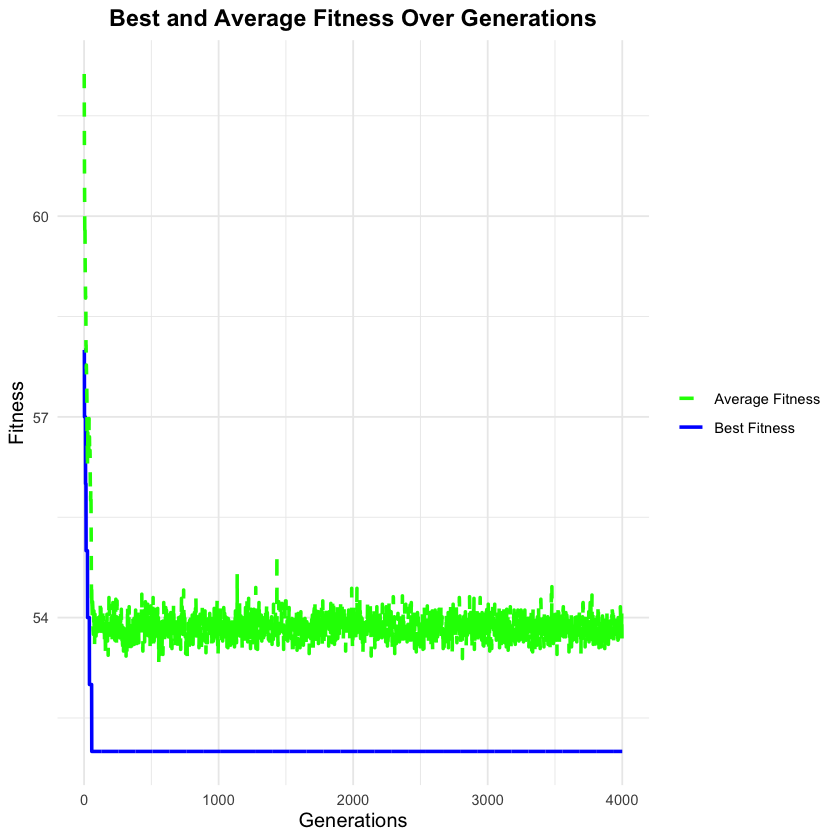

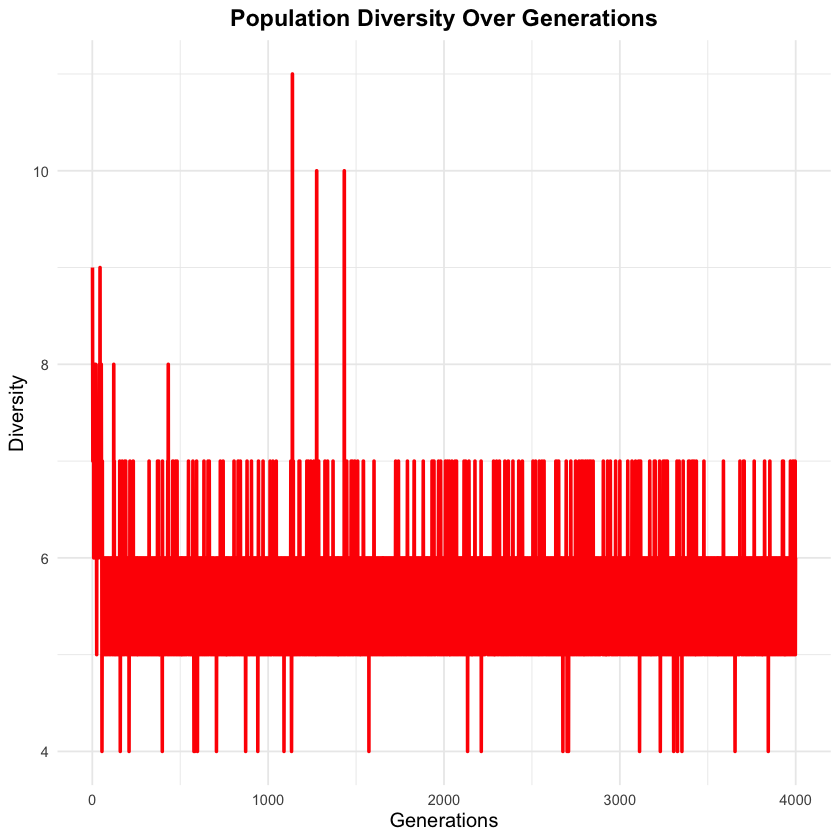

In [68]:
instance <- instances[[1]]
generationsNumber <- 4000;
bp <- BinPacking$new(item_sizes = instance$items, bin_capacity = instance$bin_capacity)
result <- GA(bp, 
             population_size = 80, 
             mutation_rate = 0.01, 
             generations = generationsNumber, 
             elite_ratio = 0.1, 
             mutation_strategy = "adaptive", 
             crossover_strategy = "two_point", 
             selection_method = "tournament", 
             tournament_size = 3, 
             diversity_threshold = 0.9)
cat("Best Individual:", result$best_individual, "\nBest Fitness:", result$best_fitness, "\n")
best_fitness <- result$best_fitness_over_time
average_fitness <- result$average_fitness_over_time
diversity <- result$diversity_over_time

plot_fitness(generationsNumber, best_fitness, average_fitness)
plot_diversity(generationsNumber, diversity)

In [336]:
file_path <- "./instances/instances2.txt"
instances <- read_bin_packing_instance(file_path)

In [337]:
instance <- instances[[1]]
instance

$problem_id
[1] "instance30"

$bin_capacity
[1] 100

$num_items
[1] 30

$best_known_solution
[1] 6

$items
 [1] 29.7 36.9 25.8 38.5 27.0 23.6 22.2 26.1 23.2 22.4 39.9 30.3 27.5 36.9 24.9
[16] 20.3 22.6 39.0 32.6 21.1 28.6 23.8 34.3 37.9 37.6 37.3 38.7 25.5 25.2 27.8

Best Individual: 2 22 4 8 19 18 23 27 28 24 11 20 14 12 1 10 6 13 29 25 17 26 9 21 7 3 5 15 30 16 
Best Fitness: 9 


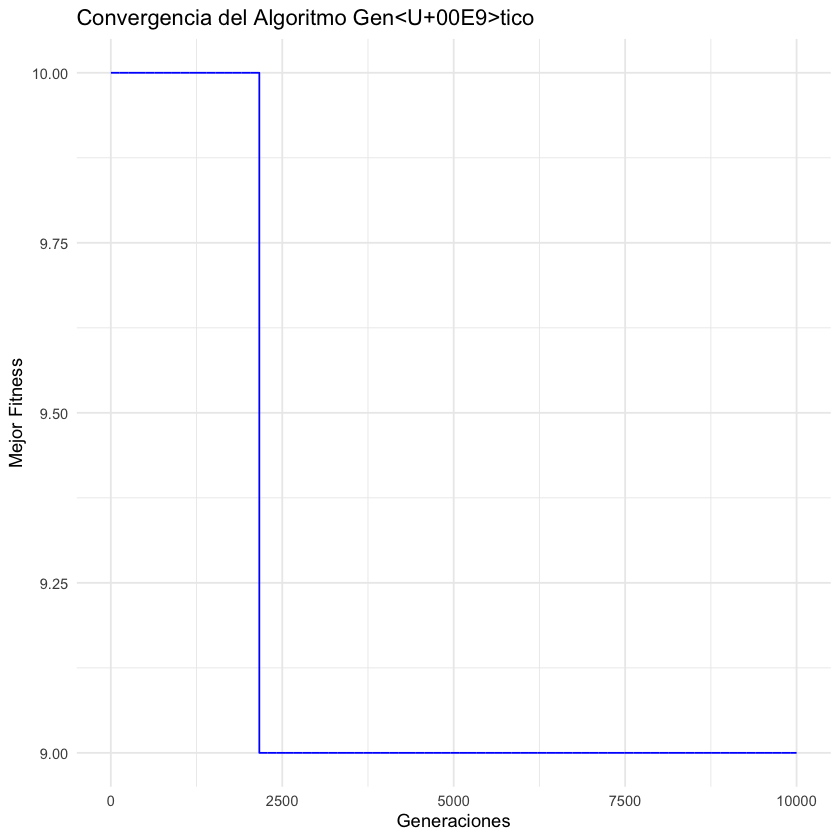

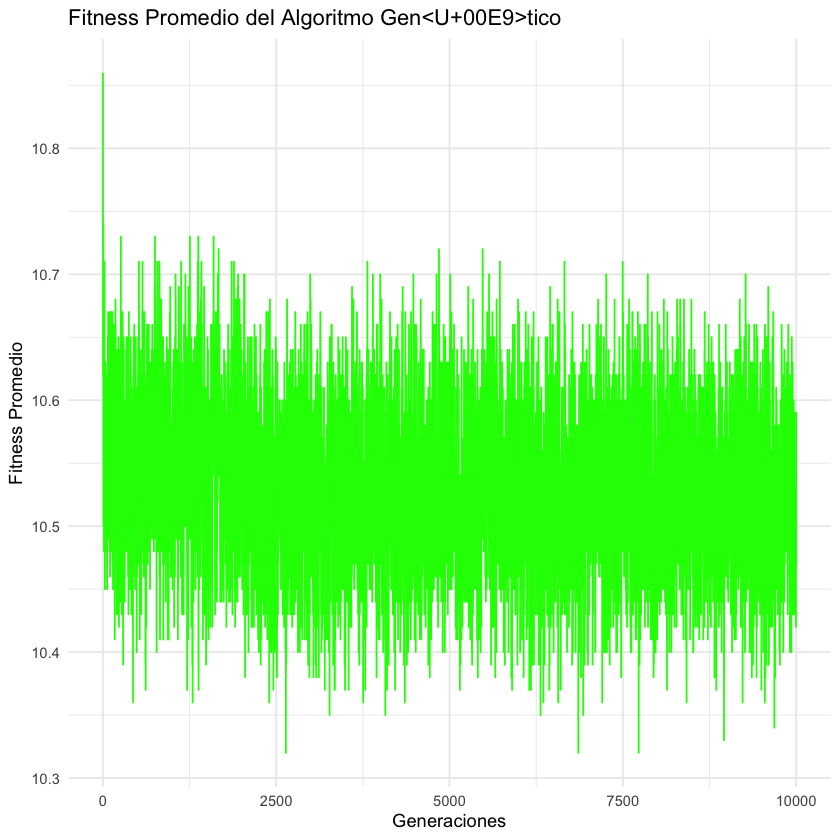

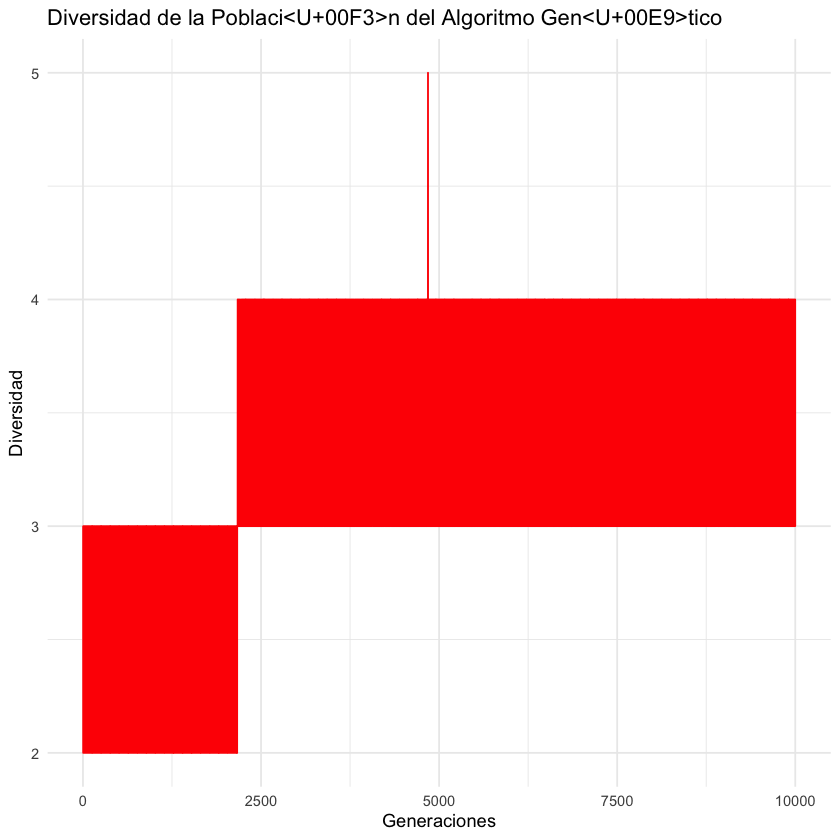

In [348]:
instance <- instances[[1]]
generationsNumber <- 10000;
bp <- BinPacking$new(item_sizes = instance$items, bin_capacity = instance$bin_capacity)
result <- GA(bp, 
             population_size = 100, 
             mutation_rate = 0.1, 
             generations = generationsNumber, 
             elite_ratio = 0.01, 
             mutation_strategy = "adaptative", 
             crossover_strategy = "two_point", 
             selection_method = "tournament", 
             tournament_size = 3, 
             diversity_threshold = 0.9)

cat("Best Individual:", result$best_individual, "\nBest Fitness:", result$best_fitness, "\n")
# Mejor fitness
fitness_data <- data.frame(Generation = 1:generationsNumber, BestFitness = result$best_fitness_over_time)
ggplot(fitness_data, aes(x = Generation, y = BestFitness)) +
  geom_line(color = "blue") +
  labs(title = "Convergencia del Algoritmo Genético", x = "Generaciones", y = "Mejor Fitness") +
  theme_minimal()

# Fitness promedio
average_fitness_data <- data.frame(Generation = 1:generationsNumber, AverageFitness = result$average_fitness_over_time)
ggplot(average_fitness_data, aes(x = Generation, y = AverageFitness)) +
  geom_line(color = "green") +
  labs(title = "Fitness Promedio del Algoritmo Genético", x = "Generaciones", y = "Fitness Promedio") +
  theme_minimal()

# Diversidad de la población
diversity_data <- data.frame(Generation = 1:generationsNumber, Diversity = result$diversity_over_time)
ggplot(diversity_data, aes(x = Generation, y = Diversity)) +
  geom_line(color = "red") +
  labs(title = "Diversidad de la Población del Algoritmo Genético", x = "Generaciones", y = "Diversidad") +
  theme_minimal()